In [58]:
from pathlib import Path
import tifffile as tiff
import time
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from path_gui import get_path, get_directory, get_int

In [59]:
from puncta_tracking import config

config.read_config('./config.yml')
config.set_trackmate_script_path('/Users/an859/Desktop/puncta_tracking/puncta_tracking/example_notebook/trackmate_script.py')

print(f"Using Fiji at: {config.get_fiji_path()}")
print(f"Using ilastik at: {config.get_ilastik_path()}")
print(f"Using trackmate script at: {config.get_trackmate_script_path()}")
print("\n")

from puncta_tracking.io import read_movie
from puncta_tracking.segment.ilastik import ilastik_segmenter
from puncta_tracking.track.trackmate import trackmate_tracker
from puncta_tracking.track.xml import extract_tracks_graphs
from puncta_tracking.props import get_regionprops, match_spots_regionprops_dist
from puncta_tracking.phase_portrait import RateCalculator, BinDataFrame


movie_file = Path('/Volumes/Desk SSD/segmentation/new cell/Merged_bgsubtract.tif')
sum_file = Path('/Volumes/Desk SSD/segmentation/new cell/Sum_Normalized_bgsubtract.tif')
ilastik_file = Path('/Volumes/Desk SSD/segmentation/new cell/MyProject.ilp')

ilastik_label = 1
num_bins = 20
min_bin_count = 5

results_dir = Path('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/bg subtract/results')

print(f"""
    Input:
        Input movie: {movie_file}
        Masks generated from: {sum_file}
        Masks generated using: {ilastik_file}

    Parameters:
        Ilastik label: {ilastik_label}
        Number of bins in each channel: {num_bins}
        Minimum count in each bin: {min_bin_count}

    Results are stored in {results_dir}
    """)
results_dir.mkdir(exist_ok=True)

Using Fiji at: /Users/an859/Downloads/Fiji.app/Contents/MacOS/ImageJ-macosx
Using ilastik at: /Users/an859/Downloads/ilastik-1.4.1.post1-arm64-OSX.app/Contents/MacOS/ilastik
Using trackmate script at: /Users/an859/Desktop/puncta_tracking/puncta_tracking/example_notebook/trackmate_script.py



    Input:
        Input movie: /Volumes/Desk SSD/segmentation/new cell/Merged_bgsubtract.tif
        Masks generated from: /Volumes/Desk SSD/segmentation/new cell/Sum_Normalized_bgsubtract.tif
        Masks generated using: /Volumes/Desk SSD/segmentation/new cell/MyProject.ilp

    Parameters:
        Ilastik label: 1
        Number of bins in each channel: 20
        Minimum count in each bin: 5

    Results are stored in /Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/bg subtract/results
    


# Ilastik segmentation

In [60]:
start_time = time.time()

# Segment sum movie
movie, movie_axes_order = read_movie(sum_file)
ret = ilastik_segmenter(movie,movie_axes_order,ilastik_label,results_dir,ilastik_file)
if ret is None:
    raise ValueError('Cannot segment with this ilastik file, check stderr and stdout logs in the results folder?')
else:x
    masks, masks_axes_order = ret

print(f"Ilastik segmentation took: {time.time() - start_time} seconds")

python(28473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ilastik segmentation took: 152.59682703018188 seconds


In [14]:
#added as new not part of pipeline
output_path = Path('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/testing 2/binary_mask.tiff')
mask_stack = tiff.imread('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/testing 2/ilastik_mask.tiff')
binary_stack = (mask_stack > 0).astype(np.uint8)*255
tiff.imwrite(output_path, binary_stack)

print(f"Binary mask saved to: {output_path}")

Binary mask saved to: /Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/testing 2/binary_mask.tiff


In [15]:
#not part of pipeline
from pathlib import Path
import tifffile as tiff
import numpy as np
from scipy.ndimage import binary_opening, binary_dilation

#Input & Output paths
input_binary_path = Path('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/testing 2/binary_mask.tiff')
modified_mask_path = Path('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/testing 2/modified_mask.tiff')

#Load binary mask
binary_stack = tiff.imread(input_binary_path)
binary_bool = binary_stack > 0  # convert to boolean mask

#Apply Binary Open
opened = binary_opening(binary_bool)

# dilate
dilated = binary_dilation(opened)

final_mask = (dilated.astype(np.uint8))

tiff.imwrite(modified_mask_path, final_mask, dtype=np.uint8)
print(f"Modified binary mask saved to: {modified_mask_path}")


Modified binary mask saved to: /Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/testing 2/modified_mask.tiff


In [6]:
#not part of pipeline
label_path = Path('/Users/an859/Desktop/ActinWaspMPI/testing_trackmate_new/terminal results/mask_label.tiff')
output_movie_path = Path("/Users/an859/Desktop/ActinWaspMPI/testing_trackmate_new/simplelap_pipeline/test_binary_label.tiff")

binary = tiff.imread(output_path) 
label = tiff.imread(label_path)

if binary.ndim == 2:
    binary = binary[np.newaxis, ...]
if label.ndim == 2:
    label = label[np.newaxis, ...]

if binary.shape != label.shape:
    raise ValueError(f"Shape mismatch: {binary.shape} vs {label.shape}")

binary = binary[:, np.newaxis, ...] 
label = label[:, np.newaxis, ...]   
merged = np.stack([binary, label], axis=2) 

tiff.imwrite(
    output_movie_path,
    merged.astype(np.uint8),  # or uint16
    imagej=True,
    metadata={'axes': 'TZCYX'}
)

print(f"File saved at: {output_movie_path}")


File saved at: /Users/an859/Desktop/ActinWaspMPI/testing_trackmate_new/simplelap_pipeline/test_binary_label.tiff


# Tracking

In [4]:
#not part of pipeline

results_dir = Path('/Users/an859/Desktop/ActinWaspMPI/testing_trackmate_new/simplelap_pipeline') 
input_movie_path = Path('/Users/an859/Desktop/ActinWaspMPI/testing_trackmate_new/simplelap_pipeline/test_binary_label.tiff')

movie, movie_axes_order = read_movie(input_movie_path)

assert movie_axes_order == "TCYX", f"Expected axes TCYX, got {movie_axes_order}"

masks = movie[:, 0]
masks_axes_order = "TYX"

intensity_movie = movie[:, 1:]
intensity_axes_order = "TCYX"

spots, edges, tracks = trackmate_tracker(movie, movie_axes_order, results_dir)

# ----- Compute region properties -----
def intensity_sum(region_mask, intensity_img):
    return np.sum(intensity_img[region_mask].flatten())

props = get_regionprops(
    intensity_movie,
    intensity_axes_order,
    masks,
    masks_axes_order,
    properties=["label", "centroid", "bbox", "intensity_mean"],
    extra_properties=(intensity_sum,)
)

# ----- Merge regionprops with spots -----
new_spots = match_spots_regionprops_dist(spots, props)

# ----- Save spot/edge/track tables -----
new_spots.to_csv(results_dir / "trackmate_spots_new.csv")
edges.to_csv(results_dir / "trackmate_edges_new.csv")
tracks.to_csv(results_dir / "trackmate_tracks_new.csv")

track_objects = extract_tracks_graphs(new_spots, edges, tracks)

# ----- Save track objects -----
with open(results_dir / "trackmate_tracks_dag_new.pkl", 'wb') as f:
    pkl.dump(track_objects, f)

KeyboardInterrupt: 

In [30]:
props

,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,intensity_mean-0,intensity_sum-0,frame
0,1,70.750000,332.250000,70,331,72,334,1.0,4.0,0
1,2,82.215190,233.177215,77,223,90,245,2.0,316.0,0
2,3,78.500000,322.000000,78,322,80,323,3.0,6.0,0
3,4,83.861111,285.388889,81,283,88,289,4.0,144.0,0
4,5,90.377049,364.614754,84,359,97,371,5.0,610.0,0
...,...,...,...,...,...,...,...,...,...,...
40536,8,218.000000,136.000000,218,136,219,137,98.0,98.0,793
40537,9,221.000000,135.000000,221,135,222,136,99.0,99.0,793
40538,10,222.000000,133.000000,222,133,223,134,100.0,100.0,793
40539,11,260.086957,97.086957,258,94,263,101,101.0,2323.0,793


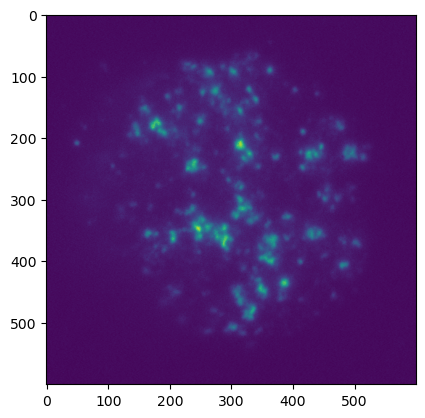

In [20]:
plt.imshow(movie[0,1])

In [61]:
start_time = time.time()

# Regionprops function for total intensity
def intensity_sum(region_mask,intensity_img):
    return np.sum(intensity_img[region_mask].flatten())

# Track on original movie
movie, movie_axes_order = read_movie(movie_file)

# Modify masks
ch_axis = movie_axes_order.index('C')
masked_movie = np.concatenate((np.expand_dims(masks,ch_axis),movie),ch_axis)

# Tracking
tmp_start_time = time.time()
spots, edges, tracks = trackmate_tracker(masked_movie,movie_axes_order,results_dir)
print(f"Trackmate took: {time.time() - tmp_start_time} seconds")


# remove regionprops whenever you are using masks generated with a particular threshold

# Add regionprops
tmp_start_time = time.time()
props = get_regionprops(movie,movie_axes_order,masks,masks_axes_order,properties=["label","centroid","bbox","intensity_mean"],extra_properties=(intensity_sum,))
print(f"Regionprops took: {time.time() - tmp_start_time} seconds")

# Merge spots with props
tmp_start_time = time.time()
new_spots = match_spots_regionprops_dist(spots,props)
print(f"Matching regionprops with trackmate output took: {time.time() - tmp_start_time} seconds")

# Save tracks and trackmate tables
new_spots.to_csv(results_dir/'trackmate_spots.csv')
edges.to_csv(results_dir/'trackmate_edges.csv')
tracks.to_csv(results_dir/'trackmate_tracks.csv')

# Make track objects
tmp_start_time = time.time()
tracks = extract_tracks_graphs(new_spots,edges,tracks)
print(f"Generating tracks took: {time.time() - tmp_start_time} seconds")

# Save track objects
with open(results_dir/'trackmate_tracks_dag.pkl','wb') as f:
    pkl.dump(tracks,f)

print(f"Total time for Trackmate and regionprops: {time.time() - start_time} seconds")

python(28587) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


OSError: Error reading file '/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/bg subtract/results/trackmate_output.xml': failed to load "/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/bg subtract/results/trackmate_output.xml": No such file or directory

In [11]:
tracks

NameError: name 'tracks' is not defined

In [48]:
start_time = time.time()

# Function to calculate rates
def grad(x,t):
    grad = np.gradient(x,t)
    return [pd.Series(grad,index=x.index)]

# Which columns to calculate rates, using what function
# Here we are using for both the same function

# we changed intensity_sum-0 : TOTAL_INTENSITY_CH2 and intensity_sum-1 : TOTAL_INTENSITY_CH3
# if ilastik segmentation cell has been run, use intensity_sum, if you use object classification, use total_intensity

rate_cols = {'intensity_sum-0': grad, 'intensity_sum-1': grad}
rc = RateCalculator.from_digraphs(tracks)
rates = rc(rate_cols, ['FRAME'])

# Save rates
rates.to_csv(results_dir/"computed_rates.csv")

# Normalize rates
val_cols = [('intensity_sum-0','val'),('intensity_sum-1','val')]
rate_cols = [('intensity_sum-0','rate_0'),('intensity_sum-1','rate_0')]
for vc, rc in zip(val_cols,rate_cols):
    mx = np.percentile(rates[vc],95)
    mn = np.percentile(rates[rc],5)
    rates[vc] = (rates[vc] - mn)/(mx - mn)
    rates[rc] = rates[rc]/(mx - mn)

# Save normalized rates
rates.to_csv(results_dir/"normalized_rates.csv") #with frame is when ['FRAME'] is added

print(f"Rate calculation took: {time.time() - start_time} seconds")

Rate calculation took: 64.70170664787292 seconds


In [25]:
#not part of pipeline
x = rates[('intensity_sum-1','val')]
y = rates[('intensity_sum-0','val')]

u = rates[('intensity_sum-0','rate_0')]
v = rates[('intensity_sum-1','rate_0')]

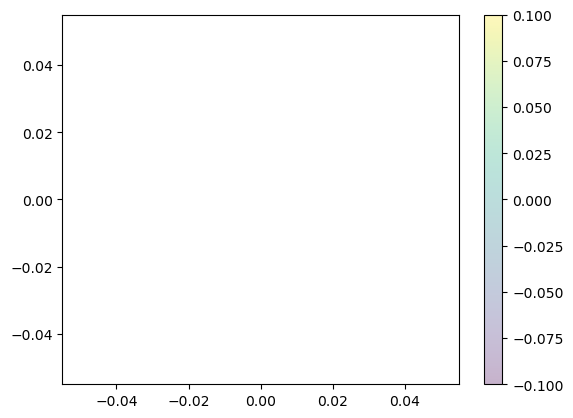

In [27]:
#not part of pipeline
plt.scatter(x,y,c=u,s=1,alpha=0.3)
plt.colorbar()
plt.show()

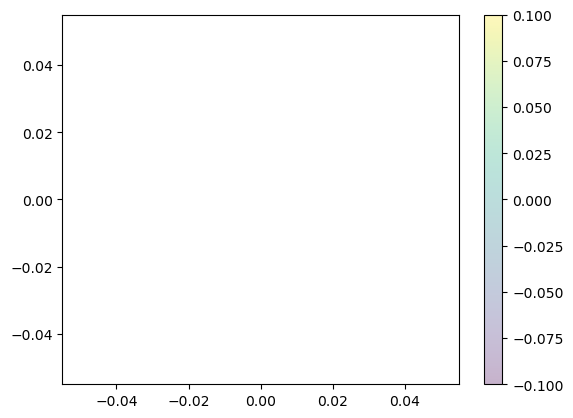

In [28]:
#not part of pipeline
plt.scatter(x,y,c=v,s=1,alpha=0.3)
plt.colorbar()
plt.show()

In [31]:
#not a part of pipeline

import tkinter as tk
from tkinter import simpledialog, filedialog
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

root = tk.Tk()
root.withdraw()  # hide main window
n_movies = simpledialog.askinteger("Input", "How many movies do you want to average phase portraits from?")
csv_files = []
for i in range(n_movies):
    file_path = filedialog.askopenfilename(title=f"Select computed_rates CSV file for movie {i+1}",
                                           filetypes=[("CSV Files", "*.csv")])
    if file_path:
        csv_files.append(file_path)

dfs = [pd.read_csv(f, header=[0,1]) for f in csv_files]  # multi-indexed columns
avg_df = sum(dfs) / len(dfs)

# ---------- Plot phase portrait ----------
x = avg_df[('intensity_sum-0', 'val')]
y = avg_df[('intensity_sum-1', 'val')]

2025-06-18 16:16:44.144 python[4589:1198576] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [49]:
start_time = time.time()

bins_cols = {col: 60 for col in val_cols}
phase_portrait = BinDataFrame(rates,bins_cols)

# Save binned phase portrait
with open(results_dir/'phase_portrait.pkl','wb') as f:
    pkl.dump(phase_portrait,f)

print(f"Binning took: {time.time() - start_time} seconds")

Binning took: 18.141555786132812 seconds


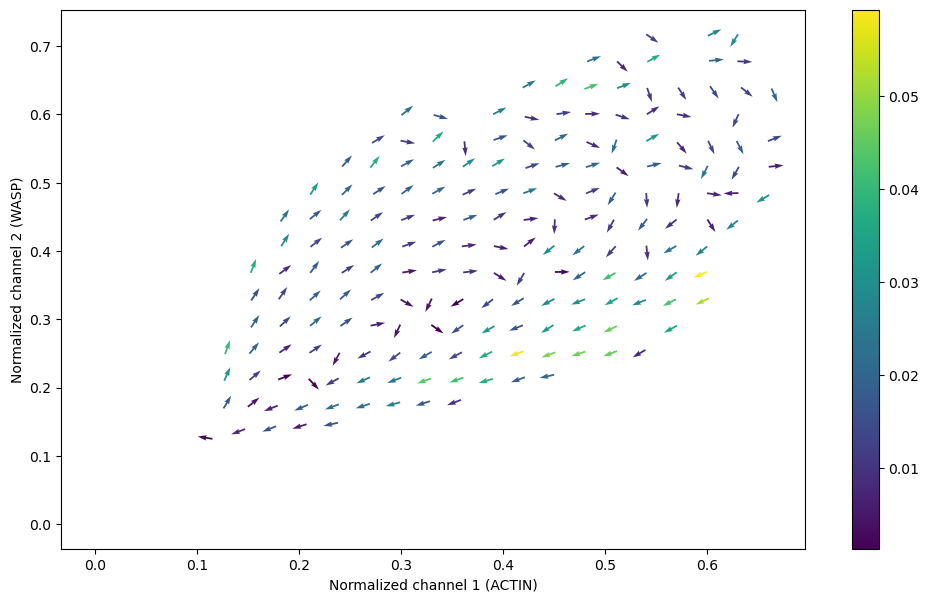

In [50]:
%matplotlib inline

plt.figure(figsize=(12,7))
plot_data = phase_portrait[...].mean()
count_data = phase_portrait[...].count()[val_cols[0]] > 70
x,y = [plot_data[v]*count_data for v in val_cols]
u,v = [plot_data[r]*count_data for r in rate_cols]
mag = np.sqrt(u**2 + v**2)
uu, uv = [i/mag for i in (u,v)]
plt.quiver(x,y,uu,uv,mag,angles='xy',scale=50)
plt.colorbar()
plt.xlabel('Normalized channel 1 (ACTIN)')
plt.ylabel('Normalized channel 2 (WASP)')

plt.savefig(results_dir/"phase_portrait.png")

plt.show()

In [17]:
#not a part of pipeline
plot_data[('intensity_sum-0','val')].shape

NameError: name 'plot_data' is not defined

In [5]:
#not part of pipeline

import tkinter as tk
from tkinter import simpledialog, filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle as pkl

from puncta_tracking.phase_portrait import BinDataFrame  # ensure this import works in your env

# Step 1: Ask number of movies
root = tk.Tk()
root.withdraw()
n_movies = simpledialog.askinteger("Input", "How many movies to average phase portraits from?", minvalue=1)

# Step 2: File dialog to choose n CSVs
csv_paths = [filedialog.askopenfilename(title=f"Select computed_rates.csv for movie {i+1}") for i in range(n_movies)]

# Step 3: Load and normalize each
val_cols = [('intensity_sum-0','val'), ('intensity_sum-1','val')]
rate_cols = [('intensity_sum-0','rate_0'), ('intensity_sum-1','rate_0')]

dfs = []
for path in csv_paths:
    df = pd.read_csv(path, header=[0, 1], index_col=0)
    df = df.copy()
    
    for vc, rc in zip(val_cols, rate_cols):
        mx = np.percentile(df[vc].dropna(), 95)
        mn = np.percentile(df[rc].dropna(), 5)
        denom = mx - mn
        if denom == 0 or np.isnan(denom):
            print(f"Skipping normalization for {vc} and {rc}: zero or NaN range.")df[vc] = 0
        df[rc] = 0
    else:
        df[vc] = (df[vc] - mn) / denom
        df[rc] = df[rc] / denom


    dfs.append(df)

# Step 4: Concatenate and bin using BinDataFrame
combined = pd.concat(dfs)

bins_cols = {col: 50 for col in val_cols}
start_time = time.time()
phase_portrait = BinDataFrame(combined, bins_cols)
print(f"Binning took: {time.time() - start_time:.2f} seconds")

# Step 5: Plotting using mean/count like your original
%matplotlib inline
plt.figure(figsize=(12, 7))

plot_data = phase_portrait[...].mean()
count_data = phase_portrait[...].count()[val_cols[0]] > 0

x, y = [plot_data[v] * count_data for v in val_cols]
u, v = [plot_data[r] * count_data for r in rate_cols]

mag = np.sqrt(u**2 + v**2)
uu, uv = [i / mag for i in (u, v)]

plt.quiver(x, y, uu, uv, mag, angles='xy', scale=50, cmap='viridis')
plt.colorbar(label='Rate magnitude')
plt.xlabel('Normalized channel 1 (ACTIN)')
plt.ylabel('Normalized channel 2 (WASP)')
plt.title('Averaged Phase Portrait from Multiple Movies')
plt.grid(True)
plt.tight_layout()
plt.show()


Binning took: 3.12 seconds


TypeError: agg function failed [how->mean,dtype->object]

In [20]:
import numpy as np
from skimage.io import imread, imsave

label_image = imread('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/export1.tif')


if label_image.any()=='#00c363':
    binary_mask=label_image.astype(np.uint8)*0
else:
    binary_mask=label_image.astype(np.uint8)*255
imsave('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/binary_mask.tif', binary_mask)  # Multiply by 255 for proper binary image visualization

In [32]:
label_image = imread('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/export1.tif')

In [33]:
label_image.shape

(538, 493, 3)

In [24]:
np.logical_and(np.logical_and(label_image[...,0] == 0,label_image[...,1] == 195), label_image[...,2] == 99)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(538, 493))

In [35]:
import numpy as np
from skimage.io import imread,imsave

binary_mask= ~np.logical_and(np.logical_and(label_image[...,0] == 255,label_image[...,1] == 255), label_image[...,2] == 255)

In [27]:
imsave('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/binary_mask.tif', binary_mask*255)

/Users/an859/Desktop/puncta_tracking/puncta_tracking/lib/python3.13/site-packages/skimage/_shared/utils.py:328: UserWarning: /Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/binary_mask.tif is a low contrast image
  return func(*args, **kwargs)


In [28]:
np.unique(binary_mask)

array([False,  True])

In [29]:
from skimage.util import img_as_uint

In [36]:
imsave('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/binary_mask.tif', img_as_uint(binary_mask))

In [40]:
folder = Path('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results')
list(folder.glob('export*.tiff'))




[PosixPath('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results/export_T=0000.tiff'),
 PosixPath('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results/export_T=0001.tiff'),
 PosixPath('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results/export_T=0002.tiff'),
 PosixPath('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results/export_T=0003.tiff'),
 PosixPath('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results/export_T=0004.tiff'),
 PosixPath('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results/export_T=0005.tiff'),
 PosixPath('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/object classification results/export_T=0006.tiff'),
 PosixPath('/Volumes/Desk SSD/Lily/Actin 

In [3]:
import numpy as np
from skimage.io import imread, imsave

folder = Path('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/lower threshold test/masks')

export_movie = np.array([imread(m) for m in folder.glob('export*.tiff')])

R,G,B = 255,255,255

bkg_mask = np.logical_and(np.logical_and(export_movie[...,0] == R, export_movie[..., 1] == G), export_movie[...,2] == B)

export_movie[bkg_mask] = 0
masks = np.sum(export_movie, axis=-1)



np.uint64(0)

In [78]:
imsave('/Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/results of threshold and normalized/results/mask_with_threshold.tiff', img_as_uint(masks))

/Users/an859/Desktop/puncta_tracking/puncta_tracking/lib/python3.13/site-packages/skimage/util/dtype.py:527: UserWarning: Downcasting uint64 to uint16 without scaling because max value 618 fits in uint16
  return _convert(image, np.uint16, force_copy)
/Users/an859/Desktop/puncta_tracking/puncta_tracking/lib/python3.13/site-packages/skimage/_shared/utils.py:328: UserWarning: /Volumes/Desk SSD/Lily/Actin Cortex Project/24 Hours Cap-1 RNAi/20240820/sum of normalized channels/results of threshold and normalized/results/mask_with_threshold.tiff is a low contrast image
  return func(*args, **kwargs)


In [57]:
from skimage.util import img_as_uint
from skimage.io import imread, imsave

movie = imread('/Volumes/Desk SSD/segmentation/new cell/Merged_bgsubtract.tif')
movie = np.swapaxes(movie,0,1)
# Assuming CTYX axes ordering
norm_movie = []
for ch in range(movie.shape[0]):
	norm_movie.append((movie[ch] - movie[ch].min())/(movie[ch].max() - movie[ch].min())) # Or any other normalization you choose to do
norm_movie = np.array(norm_movie)

# Sum over channels
norm_movie = norm_movie.sum(axis=0) # Assuming CTYX axes ordering

# Convert it back to 16bit integers, otherwise FIJI will never load them
norm_movie = (norm_movie - norm_movie.min())/(norm_movie.max() - norm_movie.min()) # Required for img_as_uint, floats must be within -1 to 1
norm_movie = img_as_uint(norm_movie)

# Save
imsave('/Volumes/Desk SSD/segmentation/new cell/Sum_Normalized_bgsubtract.tif',norm_movie,imagej=True,metadata={'axes':'tyx'})

/var/folders/7s/7myj5cqn4qlb4p4f6th816fr0000gq/T/ipykernel_2784/955351024.py:20: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imsave`.
  imsave('/Volumes/Desk SSD/segmentation/new cell/Sum_Normalized_bgsubtract.tif',norm_movie,imagej=True,metadata={'axes':'tyx'})


In [63]:
import tkinter as tk
from tkinter import filedialog, simpledialog, messagebox
import pandas as pd
import pickle
import os
import numpy as np
import time

root = tk.Tk()
root.withdraw()

results_dir = Path(get_directory(title= "Please select the folder where you would like to store the csv files."))

# Load new_spots from file
spots_path = Path(get_path(title = "Please select the trackmate_spots.csv file", multiple = False))

new_spots = pd.read_csv(spots_path)

frame_values = new_spots['FRAME'].unique()

for i in range(len(frame_values)):
    # Matching the frame numbers
    frame_number = i
    matched = new_spots[np.isclose(new_spots['FRAME'], frame_number)]
    if matched.empty:
        messagebox.showinfo("No Spots", f"No spots found at frame {frame_number}.")
        exit()
    spot_output = matched[['POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY_CH2', 'TOTAL_INTENSITY_CH3']].copy()
    spot_output.insert(0, 'Spot_ID', range(1, len(spot_output)+1))  #Number the spots from 1
    
    # save
    output_path = os.path.join(results_dir, f'spots_table_frame_{frame_number}.csv')
    spot_output.to_csv(output_path, index = False)